# ✅ Импорты

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os

from time import time

import numpy as np
import pandas as pd

from sklearn.linear_model import HuberRegressor

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier

from sklift.models import (
    SoloModel,
    TwoModels,
    ClassTransformation
)
from sklift.metrics import (
    uplift_at_k,
    qini_auc_score,
    weighted_average_uplift,
    uplift_by_percentile
)

from catboost import (
    CatBoostClassifier,
    Pool
)

from upninja.utils.Viz import (
    plot_qini_curve,
    plot_uplift_by_percentile
)
from upninja.utils.Score import uplift_score

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

# ✅ Загрузим X5 Retail Hero dataset

In [3]:
DATA_PATH = 'data/retailhero-uplift/data'

In [4]:
%%time

clients = pd.read_csv(os.path.join(DATA_PATH, 'clients.csv'))
products = pd.read_csv(os.path.join(DATA_PATH, 'products.csv'))
purchases = pd.read_csv(os.path.join(DATA_PATH, 'purchases.csv'))
train = pd.read_csv(os.path.join(DATA_PATH, 'uplift_train.csv'))
test = pd.read_csv(os.path.join(DATA_PATH, 'uplift_test.csv'))

CPU times: user 19.4 s, sys: 4.85 s, total: 24.2 s
Wall time: 26.3 s


## ⚒️ Препроцессинг X5 Retail Hero dataset

In [5]:
%%time

product_cols = ['product_id', 'is_alcohol', 'is_own_trademark']

purchases = purchases.merge(products[product_cols], 
                            on='product_id',
                            how='left'
                           )

purchases['transaction_datetime'] = pd.to_datetime(purchases['transaction_datetime'])

# агрегаты по клиенту:
client_features = purchases.groupby('client_id').agg(
    n_transactions=('transaction_id', 'nunique'),
    sum_trn_sum=('trn_sum_from_iss', 'sum'),
    mean_trn_sum=('trn_sum_from_iss', 'mean'),
    sum_quantity=('product_quantity', 'sum'),
    alcohol_bought=('is_alcohol', 'sum'),
    own_trademark_bought=('is_own_trademark', 'sum'),
    n_unique_products=('product_id', 'nunique'),
    n_days_active=('transaction_datetime', lambda x: x.nunique()),
    last_transaction_days_ago=('transaction_datetime', lambda x: (pd.Timestamp('2019-03-18') - x).max().days)
)

CPU times: user 36.3 s, sys: 1.97 s, total: 38.3 s
Wall time: 38.6 s


In [6]:
%%time

clients['first_issue_date'] = pd.to_datetime(clients['first_issue_date'])
clients['first_redeem_date'] = pd.to_datetime(clients['first_redeem_date'])

clients['issue_ts'] = clients['first_issue_date'].map(pd.Timestamp.timestamp)
clients['redeem_ts'] = clients['first_redeem_date'].apply(
    lambda x: x.timestamp() if pd.notna(x) else np.nan
)

CPU times: user 512 ms, sys: 17.1 ms, total: 529 ms
Wall time: 528 ms


In [7]:
# объединяем с агрегатами:
train_full = train.merge(clients, on='client_id', how='left')
train_full = train_full.merge(client_features, on='client_id', how='left')

test_full = test.merge(clients, on='client_id', how='left')
test_full = test_full.merge(client_features, on='client_id', how='left')

In [8]:
train_full.to_csv(os.path.join(DATA_PATH, 'uplift_train_preproc.csv'))
test_full.to_csv(os.path.join(DATA_PATH, 'uplift_test_preproc.csv'))

## ⚙️ Baseline

In [9]:
%%time

train_full = pd.read_csv(os.path.join(DATA_PATH, 'uplift_train_preproc.csv'))
test_full = pd.read_csv(os.path.join(DATA_PATH, 'uplift_test_preproc.csv'))

CPU times: user 307 ms, sys: 28.8 ms, total: 336 ms
Wall time: 335 ms


In [10]:
train_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200039 entries, 0 to 200038
Data columns (total 19 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Unnamed: 0                 200039 non-null  int64  
 1   client_id                  200039 non-null  object 
 2   treatment_flg              200039 non-null  int64  
 3   target                     200039 non-null  int64  
 4   first_issue_date           200039 non-null  object 
 5   first_redeem_date          182493 non-null  object 
 6   age                        200039 non-null  int64  
 7   gender                     200039 non-null  object 
 8   issue_ts                   200039 non-null  float64
 9   redeem_ts                  182493 non-null  float64
 10  n_transactions             200039 non-null  int64  
 11  sum_trn_sum                200039 non-null  float64
 12  mean_trn_sum               200039 non-null  float64
 13  sum_quantity               20

In [11]:
target_name = 'target'
treatment_name = 'treatment_flg'

baseline_selector = [
    feat for feat in train_full.select_dtypes(exclude='object').columns
         if feat not in ('id', 'Unnamed: 0', target_name, treatment_name)
         and not train_full[feat].isna().any().any()
]

baseline_selector

['age',
 'issue_ts',
 'n_transactions',
 'sum_trn_sum',
 'mean_trn_sum',
 'sum_quantity',
 'alcohol_bought',
 'own_trademark_bought',
 'n_unique_products',
 'n_days_active',
 'last_transaction_days_ago']

In [12]:
train_full[baseline_selector].describe()

,age,issue_ts,n_transactions,sum_trn_sum,mean_trn_sum,sum_quantity,alcohol_bought,own_trademark_bought,n_unique_products,n_days_active,last_transaction_days_ago
count,200039.000000,2.000390e+05,200039.000000,200039.000000,200039.000000,200039.000000,200039.000000,200039.000000,200039.000000,200039.000000,200039.000000
mean,46.417329,1.515492e+09,20.120821,8398.786037,75.437531,142.527997,1.916926,17.433061,75.287259,20.120781,96.268868
std,49.532475,1.759508e+07,17.732130,8627.434880,34.422622,140.550727,5.126671,19.139443,56.378792,17.732053,26.991088
min,-7491.000000,1.491330e+09,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,2.000000
25%,34.000000,1.500656e+09,8.000000,3096.000000,58.449771,53.000000,0.000000,5.000000,35.000000,8.000000,92.000000
50%,45.000000,1.510779e+09,15.000000,5996.000000,70.309524,104.000000,0.000000,12.000000,62.000000,15.000000,109.000000
75%,59.000000,1.529517e+09,27.000000,10863.000000,85.626551,188.000000,2.000000,23.000000,101.000000,27.000000,113.000000
max,1852.000000,1.552686e+09,320.000000,498973.000000,4427.000000,10614.000000,183.000000,489.000000,1364.000000,320.000000,116.000000


In [13]:
X_train_full = train_full[baseline_selector]
y_full = train_full[target_name]
treat_full = train_full[treatment_name]

X_test = test_full[[
    feat for feat in baseline_selector
         if feat not in ('target', 'treatment_flg', target_name, treatment_name)
]]

X_train, X_val, y_train, y_val, treat_train, treat_val = train_test_split(
    X_train_full, y_full, treat_full,
    test_size=0.2,
    random_state=42,
    stratify=treat_full.astype(str) + y_full.astype(str)
)

# Two-Model подход: обучаем отдельные модели для treatment и control
tm = TwoModels(
    estimator_trmnt=RandomForestClassifier(n_estimators=100, random_state=42),
    estimator_ctrl=RandomForestClassifier(n_estimators=100, random_state=42),
    method='vanilla'  # разность предсказаний: P(Y=1|X,T=1) - P(Y=1|X,T=0)
)

In [14]:
%%time

tm = TwoModels(
    estimator_trmnt=RandomForestClassifier(n_estimators=200, max_depth=8, random_state=42, n_jobs=-1),
    estimator_ctrl=RandomForestClassifier(n_estimators=200, max_depth=8, random_state=42, n_jobs=-1),
    method='vanilla'
)

tm.fit(X_train, y_train, treat_train)

uplift_val = tm.predict(X_val)

CPU times: user 28.2 s, sys: 285 ms, total: 28.5 s
Wall time: 3.12 s


## 🔮 Baseline Аналитика

### ⭐ Uplift at 30%

In [15]:
# ранжируем treatment и control отдельно:
#    -отбираем топ-30% клиентов по uplift’у, и среди них есть и treatment, и control

uplift_30 = uplift_at_k(
    y_true=y_val,
    uplift=uplift_val,
    treatment=treat_val,
    strategy='by_group',
    k=0.3
)
print(f'Uplift@30%: {uplift_30:.4f}')

Uplift@30%: 0.0571


### ⭐ Quini AUC

In [16]:
auqc = qini_auc_shape = qini_auc_score(y_val, uplift_val, treat_val)
print(f"Qini AUC (AUQC): {auqc:.4f}")

Qini AUC (AUQC): 0.0121


### ⭐ Weighted average uplift

In [17]:
wau = weighted_average_uplift(y_val, uplift_val, treat_val, bins=10)
print(f"Weighted Average Uplift: {wau:.4f}")

Weighted Average Uplift: 0.0334


### ⭐ Uplift by percentiles

In [18]:
uplift_bins = uplift_by_percentile(
    y_true=y_val,
    uplift=uplift_val,
    treatment=treat_val,
    strategy='overall',
    bins=10,
    std=True,
    total=False
)

pd.DataFrame(uplift_bins)

,n_treatment,n_control,response_rate_treatment,response_rate_control,uplift,std_treatment,std_control,std_uplift
percentile,,,,,,,,
0-10,2007,1994,0.543099,0.476429,0.066670,0.011119,0.011185,0.015771
10-20,1963,2038,0.541009,0.485280,0.055729,0.011247,0.011071,0.015782
20-30,2019,1982,0.576028,0.530777,0.045251,0.010998,0.011210,0.015704
30-40,1997,2004,0.596395,0.575848,0.020546,0.010979,0.011040,0.015570
40-50,2024,1977,0.625494,0.596358,0.029136,0.010758,0.011034,0.015411
50-60,2038,1963,0.665849,0.605706,0.060143,0.010449,0.011030,0.015193
60-70,2001,2000,0.654673,0.626500,0.028173,0.010629,0.010817,0.015165
70-80,1950,2051,0.696923,0.677718,0.019205,0.010408,0.010320,0.014656
80-90,2008,1992,0.724602,0.721888,0.002714,0.009969,0.010039,0.014148


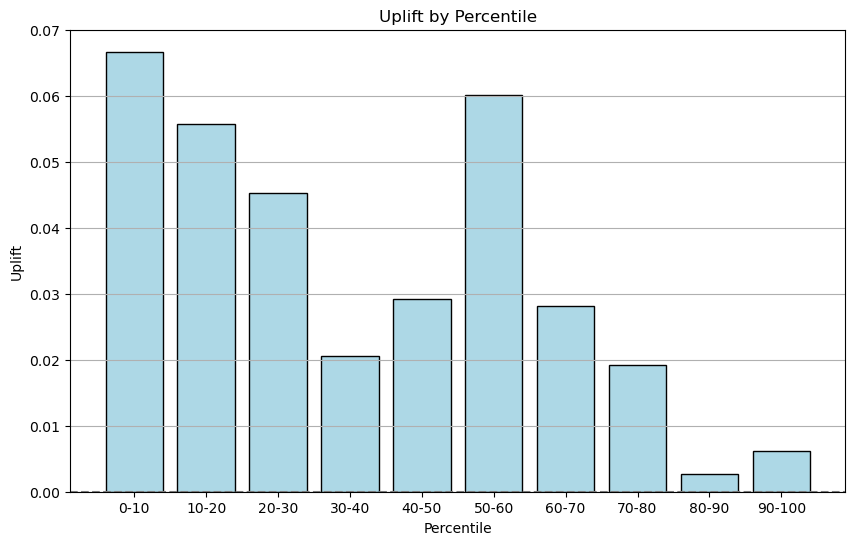

In [19]:
plot_uplift_by_percentile(
    y_val,
    uplift_val,
    treat_val
)
plt.show()

### ⭐ Qini curve

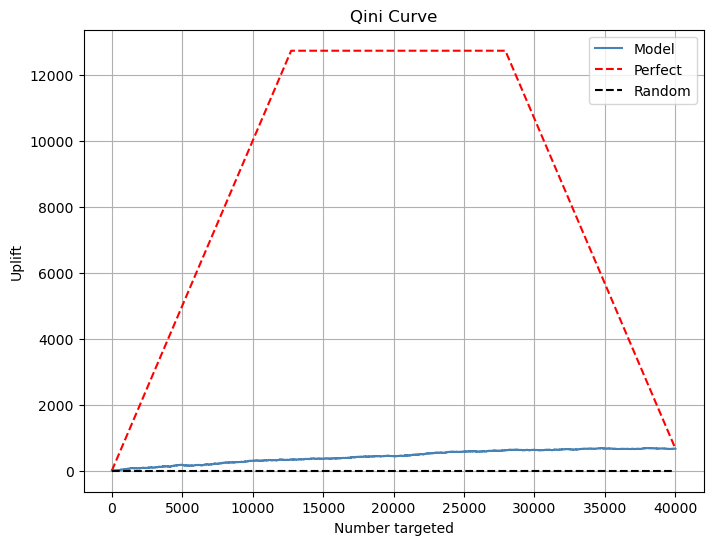

In [20]:
plot_qini_curve(y_val, uplift_val, treat_val, perfect=True)
plt.show()

# ✅ Добавим функцию для оценки Uplift-а

In [21]:
print('🚩Baseline uplift-score: ', uplift_score(uplift_val, treat_val, y_val))

🚩Baseline uplift-score:  0.057099937304883164


# ✅ Подберем лучший классический подход

# [TO DO: ❗check data leakeage + data preprocessing order❗]

In [ ]:
train_full.to_csv(os.path.join(DATA_PATH, 'uplift_train_preproc.csv'))
test_full.to_csv(os.path.join(DATA_PATH, 'uplift_test_preproc.csv'))

In [ ]:
train_full.head()

In [ ]:
target_name = 'target'
treatment_name = 'treatment_flg'
drop_feat = ['client_id', 'Unnamed: 0']

X_train_full = train_full.drop(drop_feat, axis=1).copy()

y_full = train_full[target_name].copy()
treat_full = train_full[treatment_name].copy()

X_test = test_full[[
    feat for feat in test_full.columns
         if feat not in (target_name, treatment_name)
         and feat not in drop_feat
]]

X_train, X_val, y_train, y_val, treat_train, treat_val = train_test_split(
    X_train_full, y_full, treat_full,
    test_size=0.2,
    random_state=42,
    stratify=treat_full.astype(str) + y_full.astype(str)
)

In [ ]:
X_train.isna().any().any()

In [ ]:
X_train.isna().any().any()

In [ ]:
X_test.isna().any().any()

In [ ]:
def missing_stats(dataset):
    res = []
    for col in dataset.columns:
        res.append([
            col,
            1.0 - np.mean(dataset[col].isnull()),
            dataset[col].dtype
        ])
    res = pd.DataFrame(res, columns=['feature', 'hitrate', 'dtype'])
    res = res.sort_values(by=['hitrate'], ascending=True)
    res.reset_index(drop=True, inplace=True)
    return res

res_missing = missing_stats(X_train)
res_missing

In [ ]:
fill_mice = res_missing[
                (res_missing['hitrate'] < 1) &
                ~(res_missing['dtype'] == 'object')
            ]['feature']
fill_dt = res_missing[
                (res_missing['hitrate'] < 1) &
                (res_missing['dtype'] == 'object')
            ]['feature']

imputed = IterativeImputer(
    estimator=HuberRegressor(),
    max_iter=10,
    random_state=42
).fit_transform(X_train[fill_mice])
X_train[fill_mice] = imputed

X_train[fill_dt] = X_train[fill_dt].fillna(-1)

In [ ]:
X_train.isna().any().any()

In [ ]:
to_dt = ['first_issue_date', 'first_redeem_date']

for feat in to_dt:
    X_train[feat] = pd.to_datetime(X_train[feat], errors='coerce')
    X_test[feat] = pd.to_datetime(X_test[feat], errors='coerce')

for feat in to_dt:
    X_train[feat] = X_train[feat].astype('int64') // 10**9
    X_test[feat] = X_test[feat].astype('int64') // 10**9

X_train[to_dt] = X_train[to_dt].replace(-9223372036854775808, np.nan).fillna(-1)
X_test[to_dt] = X_test[to_dt].replace(-9223372036854775808, np.nan).fillna(-1)

In [ ]:
X_test.head()

In [ ]:
cat_features = ['gender']

bm = CatBoostClassifier(
    verbose=100, 
    cat_features=cat_features,
    random_state=42,
    thread_count=-1,
    iterations=1000
)

uplift_models = {
    'solo-model': SoloModel(bm.copy()),
    'class-transformation': ClassTransformation(bm.copy()),
    'two-models-undepended': TwoModels(
                                 estimator_trmnt=bm.copy(),
                                 estimator_ctrl=bm.copy(),
                                 method='vanilla'
                             ),
    'two-models-depended-control-first': TwoModels(
                                 estimator_trmnt=bm.copy(),
                                 estimator_ctrl=bm.copy(),
                                 method='ddr_control'
                             ),
    'two-models-depended-treatment-first': TwoModels(
                                 estimator_trmnt=bm.copy(),
                                 estimator_ctrl=bm.copy(),
                                 method='ddr_treatment'
                             )
}

res = []

for model_name, model in tqdm(uplift_models.items()):
    t_start = time()
    print(f'✅ start fitting: {model_name}')
    model.fit(X_train, y_train, treat_train)
    t_fit = time() - t_start
    uplift_val = model.predict(X_val)
    uplift_30 = uplift_at_k(
                    y_true=y_val,
                    uplift=uplift_val,
                    treatment=treat_val,
                    strategy='by_group',
                    k=0.3
                )
    res.append([model_name, t_fit, uplift_30])

res = pd.DataFrame(res, columns=['Approach', 'Fitting time', 'Uplift at 30%'])

In [ ]:
res